# **Imports & Functions**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
from glob import glob
from pathlib import Path
import os
import tensorflow.keras as keras
from sklearn.metrics import recall_score

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
def plotter(history_dict):
  """
  Plots loss, val_loss of multiple models on the same graph.

  Input:
   - history_dict: dictionary of model names (keys) and history objects (values)
  """
  plt.figure(figsize=(8, 6))
  plt.xscale('log')
  #plt.xlim([5, max(plt.xlim())])
  plt.ylim([0.1, 1])
  plt.grid(True)

  for model_name in history_dict.keys(): # loop over the passed model names
    history = history_dict[model_name] # get history variable from the dictionary
    plt.plot(history.history['loss'],
             linestyle='-', # solid line
             label = model_name + ' Train')
    plt.plot(history.history['val_loss'],
             linestyle='--', # dashed line
             label = model_name + ' Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

  plt.legend(loc='lower left')
  plt.show()

In [ ]:
def find_max(arr):
    #find maximum value
    max_value = np.array([])
    for i, j in zip(arr,range(len(arr))):
        max_val = np.where(i==max(i))
        max_value = np.append(max_value,  max_val)
    return max_value

# **Downloading & Exploring Dataset**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1gbyLp0AIDRxR4CtITixQPpiTm-xwyUBJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [ ]:
!mkdir /content/Fake_Real_Faces
!unzip -q /content/archive.zip -d /content/Fake_Real_Faces

In [ ]:
DATASET_DIR = os.path.join("/content/Fake_Real_Faces/real_vs_fake/real-vs-fake", "")
TRAIN_DIR = os.path.join(DATASET_DIR, "train", "")
TEST_DIR = os.path.join(DATASET_DIR, "test", "")
VAL_DIR = os.path.join(DATASET_DIR, "valid", "")

all_data= [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]

print(len(all_data))
all_data[:10]

140000


['/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/6HEUXLCQNM.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/PFNJ4VFQ4N.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/ZQKVV1RZ71.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/O7VELO9M26.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/57EVY2XN0G.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/U84YN9CIL2.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/6UI970CAXP.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/RQR9L8XH8Y.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/RBWFMJPWPY.jpg',
 '/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid/fake/8HCVKS77DY.jpg']

In [ ]:
!mkdir /content/output/train
!mkdir /content/output/test
!mkdir /content/output/val
train_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/train"
test_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/test"
val_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid"
output_train = "/content/output/train"
output_test = "/content/output/test"
output_val = "/content/output/val"

splitfolders.ratio(train_folder, output=output_train , seed=42, ratio=(.1,.9))
splitfolders.ratio(test_folder , output=output_test  , seed=42, ratio=(.1,.9))
splitfolders.ratio(val_folder  , output=output_val   , seed=42, ratio=(.1,.9))

mkdir: cannot create directory ‘/content/output/train’: No such file or directory
mkdir: cannot create directory ‘/content/output/test’: No such file or directory
mkdir: cannot create directory ‘/content/output/val’: No such file or directory


Copying files: 100000 files [01:34, 1053.53 files/s]
Copying files: 20000 files [00:18, 1069.62 files/s]
Copying files: 20000 files [00:18, 1088.72 files/s]


In [ ]:
TRAIN_DIR_SAMPLE = os.path.join("/content/output/train", "train", "")
TEST_DIR_SAMPLE = os.path.join("/content/output/test", "train", "")
VAL_DIR_SAMPLE = os.path.join("/content/output/val", "train", "")

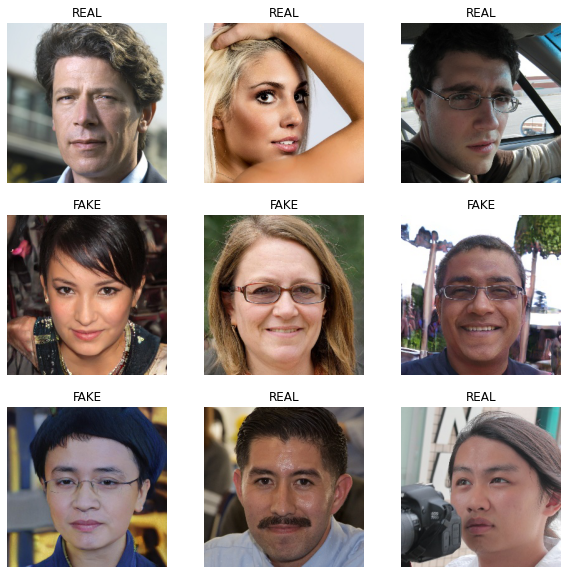

In [ ]:
# Sample 9 images from real
indices = np.random.randint(0, len(all_data), size=9)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 9 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(3, 3, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i].upper())
    plt.axis('off')

plt.show()

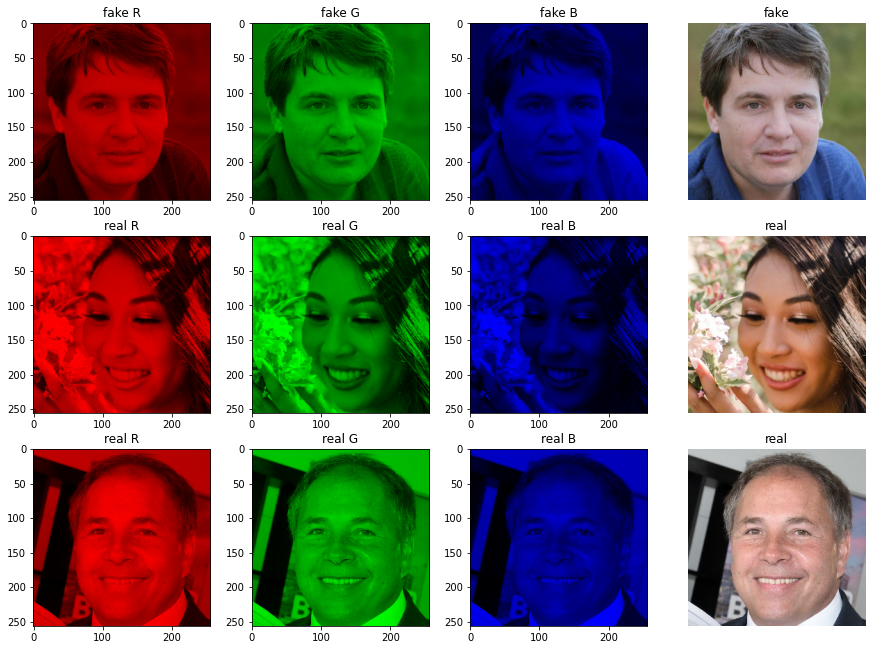

In [ ]:
indices = np.random.randint(0, len(all_data), size=3)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 1 images
x=0
plt.figure(figsize=(15,15))
for i in range(3):
    image = mpimg.imread(images[i])
    x+=1
    b = image.copy()
    b[:, :, 1] = 0
    b[:, :, 2] = 0
    plt.subplot(4, 4, x)
    plt.title(str(labels[i])+' R')
    plt.imshow(b)

    x+=1
    g = image.copy()
    g[:, :, 0] = 0
    g[:, :, 2] = 0
    plt.subplot(4, 4, x)
    plt.title(str(labels[i])+' G')
    plt.imshow(g)

    x+=1
    r = image.copy()
    r[:, :, 0] = 0
    r[:, :, 1] = 0
    plt.subplot(4, 4, x)
    plt.title(str(labels[i])+' B')
    plt.imshow(r)

    x+=1
    plt.subplot(4, 4, x)
    plt.title(str(labels[i]))
    plt.imshow(image)
    plt.axis('off')

plt.show()

#**Defining Generators**

In [ ]:
BATCH_SIZE = 256
HEIGHT = 256
WIDTH = 256

train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=40,
      horizontal_flip=True,
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR_SAMPLE,
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 10000 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    VAL_DIR_SAMPLE,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

test_generator = test_generator.flow_from_directory(TEST_DIR_SAMPLE,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = False,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


# **Training & Testing Models**

## **Hyperparameters & Model Imports**

In [ ]:
0#import all the models

from keras.applications.efficientnet          import EfficientNetB0
from keras.applications.efficientnet          import EfficientNetB1
from keras.applications.efficientnet          import EfficientNetB2
from keras.applications.efficientnet          import EfficientNetB3
from keras.applications.efficientnet          import EfficientNetB4
from keras.applications.efficientnet          import EfficientNetB5
from keras.applications.efficientnet          import EfficientNetB6
from keras.applications.efficientnet          import EfficientNetB7

from keras.applications.efficientnet_v2       import EfficientNetV2B0
from keras.applications.efficientnet_v2       import EfficientNetV2B1
from keras.applications.efficientnet_v2       import EfficientNetV2B2
from keras.applications.efficientnet_v2       import EfficientNetV2B3

from keras.applications.resnet                import ResNet50
from keras.applications.resnet                import ResNet101
from keras.applications.resnet                import ResNet152
from keras.applications.resnet_v2             import ResNet101V2
from keras.applications.resnet_v2             import ResNet50V2

from keras.applications.densenet              import DenseNet121
from keras.applications.densenet              import DenseNet169
from keras.applications.densenet              import DenseNet201

from keras.applications.inception_resnet_v2   import InceptionResNetV2
from keras.applications.inception_v3          import InceptionV3
from keras.applications.mobilenet             import MobileNet
from keras.applications.mobilenet_v2          import MobileNetV2
from keras.applications.vgg16                 import VGG16
from keras.applications.vgg19                 import VGG19
from keras.applications.xception              import Xception

In [ ]:
#Training Parameters
EPOCHS = 10
base_learning_rate = 0.0009
Optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate)
EarlyStopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

In [ ]:
#Classification Head Creation
def MakeModel(Transfer_Model):
  for layer in Transfer_Model.layers:
    layer.trainable = False

  x = Flatten()(Transfer_Model.layers[-1].output)
  x = Dense(758, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)

# return new model
  return Model(inputs = Transfer_Model.inputs, outputs = output)


In [ ]:
#Dict to save losses for comparison
histories = {}

## **EfficientNet Models**

### EfficientNetB0 Model

In [ ]:
# EfficientNetB0 Model
model = EfficientNetB0(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB0_checkpoint.h5"

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB0']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 3.8200 - accuracy: 0.5865
Epoch 1: val_loss improved from inf to 0.64216, saving model to EfficientNetB0_checkpoint.h5
40/40 [==============================] - 184s 4s/step - loss: 3.8200 - accuracy: 0.5865 - val_loss: 0.6422 - val_accuracy: 0.6725
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6495
Epoch 2: val_loss improved from 0.64216 to 0.60452, saving model to EfficientNetB0_checkpoint.h5
40/40 [==============================] - 171s 4s/step - loss: 0.6415 - accuracy: 0.6495 - val_loss: 0.6045 - val_accuracy: 0.7120
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.6791
Epoch 3: val_loss improved from 0.60452 to 0.58334, saving model to EfficientNetB0_checkpoint.h5
40/40 [==============================] - 170s 4s/step - loss: 0.6078 - accuracy: 0.6791 - val_loss: 0.5833 - val_accuracy: 0.7255
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions = model.predict(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB0 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

8/8 [==============================] - 6s 727ms/step - loss: 0.4578 - accuracy: 0.7925
EfficientNetB0 Model's Test Accuracy Is 79.25000190734863%
Recall =  0.908


### EfficientNetB1 Model

In [ ]:
# EfficientNetB1 Model
model = EfficientNetB1(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB1_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB1']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 3.3344 - accuracy: 0.5974
Epoch 1: val_loss improved from inf to 0.58904, saving model to EfficientNetB1_checkpoint.h5
40/40 [==============================] - 191s 5s/step - loss: 3.3344 - accuracy: 0.5974 - val_loss: 0.5890 - val_accuracy: 0.7065
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.6801
Epoch 2: val_loss improved from 0.58904 to 0.56897, saving model to EfficientNetB1_checkpoint.h5
40/40 [==============================] - 176s 4s/step - loss: 0.6180 - accuracy: 0.6801 - val_loss: 0.5690 - val_accuracy: 0.7265
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7119
Epoch 3: val_loss improved from 0.56897 to 0.54500, saving model to EfficientNetB1_checkpoint.h5
40/40 [==============================] - 174s 4s/step - loss: 0.5743 - accuracy: 0.7119 - val_loss: 0.5450 - val_accuracy: 0.7310
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions =model.predict(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB1 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

8/8 [==============================] - 7s 795ms/step - loss: 0.4232 - accuracy: 0.8065
EfficientNetB1 Model's Test Accuracy Is 80.65000176429749%
Recall =  0.768


### EfficientNetB2 Model

In [ ]:
# EfficientNetB2 Model
model = EfficientNetB2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.7952 - accuracy: 0.5574
Epoch 1: val_loss improved from inf to 0.67388, saving model to EfficientNetB2_checkpoint.h5
40/40 [==============================] - 194s 5s/step - loss: 1.7952 - accuracy: 0.5574 - val_loss: 0.6739 - val_accuracy: 0.5995
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6203
Epoch 2: val_loss improved from 0.67388 to 0.61372, saving model to EfficientNetB2_checkpoint.h5
40/40 [==============================] - 179s 4s/step - loss: 0.6563 - accuracy: 0.6203 - val_loss: 0.6137 - val_accuracy: 0.6755
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6721
Epoch 3: val_loss improved from 0.61372 to 0.58680, saving model to EfficientNetB2_checkpoint.h5
40/40 [==============================] - 178s 4s/step - loss: 0.6172 - accuracy: 0.6721 - val_loss: 0.5868 - val_accuracy: 0.7090
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 7s 814ms/step - loss: 0.4541 - accuracy: 0.8040
EfficientNetB2 Model's Test Accuracy Is 80.40000200271606%
Recall =  0.749


### EfficientNetB3 Model

In [ ]:
# EfficientNetB0 Model
model = EfficientNetB3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


43950080/43941136 [==============================] - 5s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB3_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB3']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.3881 - accuracy: 0.6090
Epoch 1: val_loss improved from inf to 0.59556, saving model to EfficientNetB3_checkpoint.h5
40/40 [==============================] - 225s 5s/step - loss: 1.3881 - accuracy: 0.6090 - val_loss: 0.5956 - val_accuracy: 0.7145
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6798
Epoch 2: val_loss improved from 0.59556 to 0.55979, saving model to EfficientNetB3_checkpoint.h5
40/40 [==============================] - 186s 5s/step - loss: 0.6418 - accuracy: 0.6798 - val_loss: 0.5598 - val_accuracy: 0.7025
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7150
Epoch 3: val_loss improved from 0.55979 to 0.52329, saving model to EfficientNetB3_checkpoint.h5
40/40 [==============================] - 187s 5s/step - loss: 0.5946 - accuracy: 0.7150 - val_loss: 0.5233 - val_accuracy: 0.7600
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB3 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 9s 1s/step - loss: 0.4374 - accuracy: 0.8230
EfficientNetB3 Model's Test Accuracy Is 82.30000138282776%
Recall =  0.887


### EfficientNetB4 Model

In [ ]:
# EfficientNetB4 Model
model = EfficientNetB4(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB4_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB4']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 3.0766 - accuracy: 0.5663
Epoch 1: val_loss improved from inf to 0.64270, saving model to EfficientNetB4_checkpoint.h5
40/40 [==============================] - 217s 5s/step - loss: 3.0766 - accuracy: 0.5663 - val_loss: 0.6427 - val_accuracy: 0.6115
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.6291
Epoch 2: val_loss improved from 0.64270 to 0.61479, saving model to EfficientNetB4_checkpoint.h5
40/40 [==============================] - 194s 5s/step - loss: 0.6717 - accuracy: 0.6291 - val_loss: 0.6148 - val_accuracy: 0.6900
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.6559
Epoch 3: val_loss improved from 0.61479 to 0.60054, saving model to EfficientNetB4_checkpoint.h5
40/40 [==============================] - 193s 5s/step - loss: 0.6380 - accuracy: 0.6559 - val_loss: 0.6005 - val_accuracy: 0.6970
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB4 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 12s 1s/step - loss: 0.4931 - accuracy: 0.8000
EfficientNetB4 Model's Test Accuracy Is 80.0000011920929%
Recall =  0.759


### EfficientNetB5 Model

In [ ]:
# EfficientNetB5 Model
model = EfficientNetB5(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


115277824/115263384 [==============================] - 3s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB5_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB5']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 2.1901 - accuracy: 0.5677
Epoch 1: val_loss improved from inf to 0.63147, saving model to EfficientNetB5_checkpoint.h5
40/40 [==============================] - 250s 5s/step - loss: 2.1901 - accuracy: 0.5677 - val_loss: 0.6315 - val_accuracy: 0.6635
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.6315
Epoch 2: val_loss improved from 0.63147 to 0.59860, saving model to EfficientNetB5_checkpoint.h5
40/40 [==============================] - 204s 5s/step - loss: 0.6858 - accuracy: 0.6315 - val_loss: 0.5986 - val_accuracy: 0.6810
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6615
Epoch 3: val_loss improved from 0.59860 to 0.57288, saving model to EfficientNetB5_checkpoint.h5
40/40 [==============================] - 203s 5s/step - loss: 0.6418 - accuracy: 0.6615 - val_loss: 0.5729 - val_accuracy: 0.7120
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB5 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 16s 2s/step - loss: 0.5088 - accuracy: 0.7740
EfficientNetB5 Model's Test Accuracy Is 77.39999890327454%
Recall =  0.698


### EfficientNetB6 Model

In [ ]:
# EfficientNetB6 Model
model = EfficientNetB6(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

165249024/165234480 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB6_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB6']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 2.1687 - accuracy: 0.5688
Epoch 1: val_loss improved from inf to 0.67576, saving model to EfficientNetB6_checkpoint.h5
40/40 [==============================] - 269s 6s/step - loss: 2.1687 - accuracy: 0.5688 - val_loss: 0.6758 - val_accuracy: 0.6425
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.6154
Epoch 2: val_loss improved from 0.67576 to 0.63145, saving model to EfficientNetB6_checkpoint.h5
40/40 [==============================] - 226s 6s/step - loss: 0.7106 - accuracy: 0.6154 - val_loss: 0.6315 - val_accuracy: 0.6735
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6358
Epoch 3: val_loss improved from 0.63145 to 0.58349, saving model to EfficientNetB6_checkpoint.h5
40/40 [==============================] - 219s 5s/step - loss: 0.6647 - accuracy: 0.6358 - val_loss: 0.5835 - val_accuracy: 0.7235
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB6 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,find_max(predictions), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 21s 3s/step - loss: 0.4942 - accuracy: 0.7835
EfficientNetB6 Model's Test Accuracy Is 78.35000157356262%
Recall =  0.777


### EfficientNetB7 Model

In [ ]:
# EfficientNetB7 Model
model = EfficientNetB7(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetB7_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetB7']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 4.4299 - accuracy: 0.5412
Epoch 1: val_loss improved from inf to 0.64710, saving model to EfficientNetB7_checkpoint.h5
40/40 [==============================] - 278s 6s/step - loss: 4.4299 - accuracy: 0.5412 - val_loss: 0.6471 - val_accuracy: 0.6395
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.6223
Epoch 2: val_loss improved from 0.64710 to 0.63650, saving model to EfficientNetB7_checkpoint.h5
40/40 [==============================] - 265s 7s/step - loss: 0.6826 - accuracy: 0.6223 - val_loss: 0.6365 - val_accuracy: 0.6815
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.6362
Epoch 3: val_loss improved from 0.63650 to 0.60211, saving model to EfficientNetB7_checkpoint.h5
40/40 [==============================] - 259s 6s/step - loss: 0.6488 - accuracy: 0.6362 - val_loss: 0.6021 - val_accuracy: 0.7110
Epoch 4/10
40/40 [=======================

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetB7 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 28s 3s/step - loss: 0.4987 - accuracy: 0.7845
EfficientNetB7 Model's Test Accuracy Is 78.4500002861023%
Recall =  0.724


## **EfficientNetV2 Models**

### EfficientNetV2B0 Model

In [ ]:
# EfficientNetV2B0 Model
model = EfficientNetV2B0(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetV2B0_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetV2B0']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 2.4929 - accuracy: 0.5713
Epoch 1: val_loss improved from inf to 0.62731, saving model to EfficientNetV2B0_checkpoint.h5
40/40 [==============================] - 187s 4s/step - loss: 2.4929 - accuracy: 0.5713 - val_loss: 0.6273 - val_accuracy: 0.6730
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6766
Epoch 2: val_loss improved from 0.62731 to 0.54156, saving model to EfficientNetV2B0_checkpoint.h5
40/40 [==============================] - 171s 4s/step - loss: 0.6173 - accuracy: 0.6766 - val_loss: 0.5416 - val_accuracy: 0.7610
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7151
Epoch 3: val_loss improved from 0.54156 to 0.51947, saving model to EfficientNetV2B0_checkpoint.h5
40/40 [==============================] - 183s 5s/step - loss: 0.5641 - accuracy: 0.7151 - val_loss: 0.5195 - val_accuracy: 0.7550
Epoch 4/10
40/40 [=================

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetV2B0 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 5s 618ms/step - loss: 0.4279 - accuracy: 0.8010
EfficientNetV2B0 Model's Test Accuracy Is 80.09999990463257%
Recall =  0.954


### EfficientNetV2B1 Model

In [ ]:
# EfficientNetV2B1 Model
model = EfficientNetV2B1(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


28467200/28456008 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetV2B1_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetV2B1']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.5679 
Epoch 1: val_loss improved from inf to 0.59452, saving model to EfficientNetV2B1_checkpoint.h5
40/40 [==============================] - 1015s 25s/step - loss: 1.4560 - accuracy: 0.5679 - val_loss: 0.5945 - val_accuracy: 0.7025
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6876 
Epoch 2: val_loss improved from 0.59452 to 0.51038, saving model to EfficientNetV2B1_checkpoint.h5
40/40 [==============================] - 996s 25s/step - loss: 0.6171 - accuracy: 0.6876 - val_loss: 0.5104 - val_accuracy: 0.7610
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.7390 
Epoch 3: val_loss improved from 0.51038 to 0.46002, saving model to EfficientNetV2B1_checkpoint.h5
40/40 [==============================] - 994s 25s/step - loss: 0.5486 - accuracy: 0.7390 - val_loss: 0.4600 - val_accuracy: 0.7925
Epoch 4/10
40/40 [==========

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetV2B1 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 140s 17s/step - loss: 0.3767 - accuracy: 0.8360
EfficientNetV2B1 Model's Test Accuracy Is 83.60000252723694%
Recall =  0.944


### EfficientNetV2B2 Model

In [ ]:
# EfficientNetV2B2 Model
model = EfficientNetV2B2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


35848192/35839040 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetV2B2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetV2B2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 2.0900 - accuracy: 0.5883 
Epoch 1: val_loss improved from inf to 0.61207, saving model to EfficientNetV2B2_checkpoint.h5
40/40 [==============================] - 1110s 28s/step - loss: 2.0900 - accuracy: 0.5883 - val_loss: 0.6121 - val_accuracy: 0.6845
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.6877 
Epoch 2: val_loss improved from 0.61207 to 0.54670, saving model to EfficientNetV2B2_checkpoint.h5
40/40 [==============================] - 1121s 28s/step - loss: 0.6198 - accuracy: 0.6877 - val_loss: 0.5467 - val_accuracy: 0.7460
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7255 
Epoch 3: val_loss improved from 0.54670 to 0.52649, saving model to EfficientNetV2B2_checkpoint.h5
40/40 [==============================] - 1100s 28s/step - loss: 0.5577 - accuracy: 0.7255 - val_loss: 0.5265 - val_accuracy: 0.7610
Epoch 4/10
40/40 [========

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc =model.evaluate(test_generator)
print("EfficientNetV2B2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 156s 19s/step - loss: 0.3976 - accuracy: 0.8150
EfficientNetV2B2 Model's Test Accuracy Is 81.49999976158142%
Recall =  0.941


### EfficientNetV2B3 Model

In [ ]:
# EfficientNetV2B3 Model
model = EfficientNetV2B3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

52617216/52606240 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model= MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "EfficientNetV2B3_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['EfficientNetV2B3']  =model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.4703 - accuracy: 0.5982 
Epoch 1: val_loss improved from inf to 0.60687, saving model to EfficientNetV2B3_checkpoint.h5
40/40 [==============================] - 1815s 45s/step - loss: 1.4703 - accuracy: 0.5982 - val_loss: 0.6069 - val_accuracy: 0.6970
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.6815 
Epoch 2: val_loss improved from 0.60687 to 0.52509, saving model to EfficientNetV2B3_checkpoint.h5
40/40 [==============================] - 1755s 44s/step - loss: 0.6434 - accuracy: 0.6815 - val_loss: 0.5251 - val_accuracy: 0.7515
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7234 
Epoch 3: val_loss improved from 0.52509 to 0.49433, saving model to EfficientNetV2B3_checkpoint.h5
40/40 [==============================] - 1768s 44s/step - loss: 0.5800 - accuracy: 0.7234 - val_loss: 0.4943 - val_accuracy: 0.7785
Epoch 4/10
40/40 [========

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("EfficientNetV2B3 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 251s 31s/step - loss: 0.4107 - accuracy: 0.8200
EfficientNetV2B3 Model's Test Accuracy Is 81.99999928474426%
Recall =  0.926


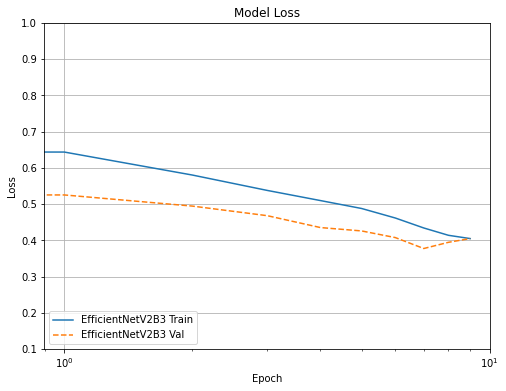

In [ ]:
plotter(histories)
histories={}

## **ResNet Models**

### ResNet50 Model

In [ ]:
# ResNet50 Model
model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet50_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet50']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 8.0919 - accuracy: 0.5661
Epoch 1: val_loss improved from inf to 0.64140, saving model to ResNet50_checkpoint.h5
40/40 [==============================] - 194s 5s/step - loss: 8.0919 - accuracy: 0.5661 - val_loss: 0.6414 - val_accuracy: 0.6695
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6551
Epoch 2: val_loss improved from 0.64140 to 0.58204, saving model to ResNet50_checkpoint.h5
40/40 [==============================] - 184s 5s/step - loss: 0.6350 - accuracy: 0.6551 - val_loss: 0.5820 - val_accuracy: 0.7190
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.6976
Epoch 3: val_loss improved from 0.58204 to 0.51605, saving model to ResNet50_checkpoint.h5
40/40 [==============================] - 185s 5s/step - loss: 0.5751 - accuracy: 0.6976 - val_loss: 0.5161 - val_accuracy: 0.7635
Epoch 4/10
40/40 [==============================] - ETA: 0s

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet50 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 9s 1s/step - loss: 0.3919 - accuracy: 0.8320
ResNet50 Model's Test Accuracy Is 83.20000171661377%
Recall =  0.955


### ResNet101 Model

In [ ]:
# ResNet101 Model
model = ResNet101(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


171458560/171446536 [==============================] - 3s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet101_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet101']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 9.1690 - accuracy: 0.5693
Epoch 1: val_loss improved from inf to 0.64514, saving model to ResNet101_checkpoint.h5
40/40 [==============================] - 210s 5s/step - loss: 9.1690 - accuracy: 0.5693 - val_loss: 0.6451 - val_accuracy: 0.6445
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.6187
Epoch 2: val_loss improved from 0.64514 to 0.61024, saving model to ResNet101_checkpoint.h5
40/40 [==============================] - 200s 5s/step - loss: 0.6559 - accuracy: 0.6187 - val_loss: 0.6102 - val_accuracy: 0.7000
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.6641
Epoch 3: val_loss improved from 0.61024 to 0.56496, saving model to ResNet101_checkpoint.h5
40/40 [==============================] - 197s 5s/step - loss: 0.6120 - accuracy: 0.6641 - val_loss: 0.5650 - val_accuracy: 0.7265
Epoch 4/10
40/40 [==============================] - ETA:

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet101 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 14s 2s/step - loss: 0.4497 - accuracy: 0.7740
ResNet101 Model's Test Accuracy Is 77.39999890327454%
Recall =  0.975


### ResNet152 Model

In [ ]:
# ResNet152 Model
model = ResNet152(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


234708992/234698864 [==============================] - 3s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet152_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet152']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 6.6932 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 0.63802, saving model to ResNet152_checkpoint.h5
40/40 [==============================] - 232s 6s/step - loss: 6.6932 - accuracy: 0.5587 - val_loss: 0.6380 - val_accuracy: 0.6505
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.6238
Epoch 2: val_loss improved from 0.63802 to 0.60315, saving model to ResNet152_checkpoint.h5
40/40 [==============================] - 215s 5s/step - loss: 0.6428 - accuracy: 0.6238 - val_loss: 0.6031 - val_accuracy: 0.6895
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6586
Epoch 3: val_loss improved from 0.60315 to 0.55442, saving model to ResNet152_checkpoint.h5
40/40 [==============================] - 222s 6s/step - loss: 0.6102 - accuracy: 0.6586 - val_loss: 0.5544 - val_accuracy: 0.7410
Epoch 4/10
40/40 [==============================] - ETA:

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet152 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 20s 2s/step - loss: 0.4031 - accuracy: 0.8190
ResNet152 Model's Test Accuracy Is 81.90000057220459%
Recall =  0.762


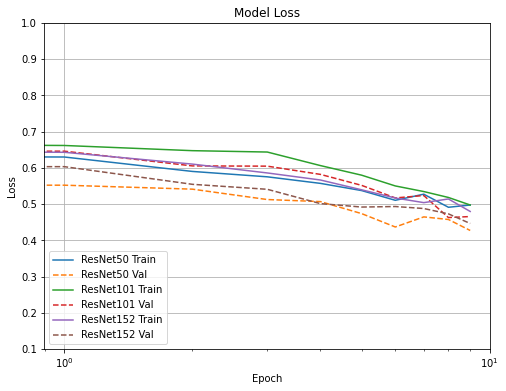

In [ ]:
plotter(histories)
histories={}

### ResNet50V2

In [ ]:
# ResNet50V2 Model
model = ResNet50V2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet50V2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet50V2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 3.7217 - accuracy: 0.5759
Epoch 1: val_loss improved from inf to 0.61598, saving model to ResNet50V2_checkpoint.h5
40/40 [==============================] - 198s 5s/step - loss: 3.7217 - accuracy: 0.5759 - val_loss: 0.6160 - val_accuracy: 0.6790
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6636
Epoch 2: val_loss improved from 0.61598 to 0.58493, saving model to ResNet50V2_checkpoint.h5
40/40 [==============================] - 185s 5s/step - loss: 0.6452 - accuracy: 0.6636 - val_loss: 0.5849 - val_accuracy: 0.7215
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.6875
Epoch 3: val_loss improved from 0.58493 to 0.57272, saving model to ResNet50V2_checkpoint.h5
40/40 [==============================] - 182s 5s/step - loss: 0.6043 - accuracy: 0.6875 - val_loss: 0.5727 - val_accuracy: 0.7330
Epoch 4/10
40/40 [==============================] - E

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet50V2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 9s 1s/step - loss: 0.4528 - accuracy: 0.8035
ResNet50V2 Model's Test Accuracy Is 80.34999966621399%
Recall =  0.897


### ResNet101V2

In [ ]:
# ResNet101V2 Model
model = ResNet101V2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


171327488/171317808 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet101V2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet101V2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 6.6525 - accuracy: 0.5783
Epoch 1: val_loss improved from inf to 0.63913, saving model to ResNet101V2_checkpoint.h5
40/40 [==============================] - 209s 5s/step - loss: 6.6525 - accuracy: 0.5783 - val_loss: 0.6391 - val_accuracy: 0.6515
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6432
Epoch 2: val_loss improved from 0.63913 to 0.60441, saving model to ResNet101V2_checkpoint.h5
40/40 [==============================] - 198s 5s/step - loss: 0.6439 - accuracy: 0.6432 - val_loss: 0.6044 - val_accuracy: 0.6905
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6691
Epoch 3: val_loss improved from 0.60441 to 0.59485, saving model to ResNet101V2_checkpoint.h5
40/40 [==============================] - 194s 5s/step - loss: 0.6170 - accuracy: 0.6691 - val_loss: 0.5949 - val_accuracy: 0.7220
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet101V2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 13s 2s/step - loss: 0.4673 - accuracy: 0.8010
ResNet101V2 Model's Test Accuracy Is 80.09999990463257%
Recall =  0.853


### ResNet152V2

In [ ]:
# ResNet152 Model
model = ResNet152V2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "ResNet152V2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['ResNet152V2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 5.8354 - accuracy: 0.5622
Epoch 1: val_loss improved from inf to 0.64927, saving model to ResNet152V2_checkpoint.h5
40/40 [==============================] - 228s 5s/step - loss: 5.8354 - accuracy: 0.5622 - val_loss: 0.6493 - val_accuracy: 0.6345
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.6408
Epoch 2: val_loss improved from 0.64927 to 0.62200, saving model to ResNet152V2_checkpoint.h5
40/40 [==============================] - 213s 5s/step - loss: 0.6485 - accuracy: 0.6408 - val_loss: 0.6220 - val_accuracy: 0.6830
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6739
Epoch 3: val_loss improved from 0.62200 to 0.57690, saving model to ResNet152V2_checkpoint.h5
40/40 [==============================] - 212s 5s/step - loss: 0.6164 - accuracy: 0.6739 - val_loss: 0.5769 - val_accuracy: 0.7100
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("ResNet152V2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 20s 2s/step - loss: 0.4814 - accuracy: 0.8075
ResNet152V2 Model's Test Accuracy Is 80.75000047683716%
Recall =  0.866


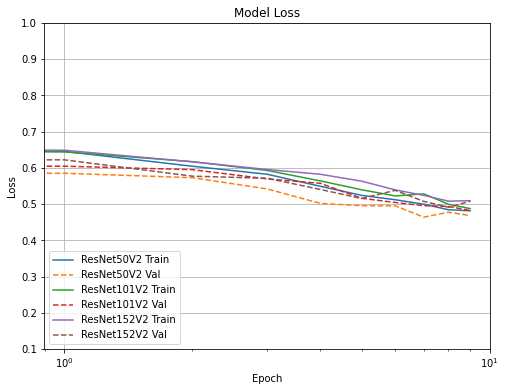

In [ ]:
plotter(histories)
histories={}

## **DenseNet Models**

### DenseNet121 Model

In [ ]:
# DenseNet121 Model
model = DenseNet121(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)

In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "DenseNet121_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['DenseNet121']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 2.2388 - accuracy: 0.5643
Epoch 1: val_loss improved from inf to 0.59249, saving model to DenseNet121_checkpoint.h5
40/40 [==============================] - 275s 6s/step - loss: 2.2388 - accuracy: 0.5643 - val_loss: 0.5925 - val_accuracy: 0.7040
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6850
Epoch 2: val_loss improved from 0.59249 to 0.52628, saving model to DenseNet121_checkpoint.h5
40/40 [==============================] - 215s 5s/step - loss: 0.5947 - accuracy: 0.6850 - val_loss: 0.5263 - val_accuracy: 0.7420
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7123
Epoch 3: val_loss improved from 0.52628 to 0.49236, saving model to DenseNet121_checkpoint.h5
40/40 [==============================] - 205s 5s/step - loss: 0.5556 - accuracy: 0.7123 - val_loss: 0.4924 - val_accuracy: 0.7880
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("DenseNet121 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 8s 924ms/step - loss: 0.4096 - accuracy: 0.8235
DenseNet121 Model's Test Accuracy Is 82.34999775886536%
Recall =  0.919


### DenseNet169 Model

In [ ]:
# DenseNet169 Model
model = DenseNet169(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)



In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "DenseNet169_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['DenseNet169']  =model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 4.3959 - accuracy: 0.5522
Epoch 1: val_loss improved from inf to 0.61385, saving model to DenseNet169_checkpoint.h5
40/40 [==============================] - 215s 5s/step - loss: 4.3959 - accuracy: 0.5522 - val_loss: 0.6139 - val_accuracy: 0.6905
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.6741
Epoch 2: val_loss improved from 0.61385 to 0.53460, saving model to DenseNet169_checkpoint.h5
40/40 [==============================] - 194s 5s/step - loss: 0.6039 - accuracy: 0.6741 - val_loss: 0.5346 - val_accuracy: 0.7605
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.7255
Epoch 3: val_loss improved from 0.53460 to 0.49811, saving model to DenseNet169_checkpoint.h5
40/40 [==============================] - 195s 5s/step - loss: 0.5418 - accuracy: 0.7255 - val_loss: 0.4981 - val_accuracy: 0.7935
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc =model.evaluate(test_generator)
print("DenseNet169 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 10s 1s/step - loss: 0.4149 - accuracy: 0.7990
DenseNet169 Model's Test Accuracy Is 79.90000247955322%
Recall =  0.968


### DenseNet201 Model

In [ ]:
# DenseNet201 Model
model = DenseNet201(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "DenseNet201_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['DenseNet201']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 7.1039 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.64860, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 230s 5s/step - loss: 7.1039 - accuracy: 0.5312 - val_loss: 0.6486 - val_accuracy: 0.6645
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.6231
Epoch 2: val_loss improved from 0.64860 to 0.59509, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 226s 6s/step - loss: 0.6449 - accuracy: 0.6231 - val_loss: 0.5951 - val_accuracy: 0.7255
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.6637
Epoch 3: val_loss improved from 0.59509 to 0.56916, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 221s 6s/step - loss: 0.5975 - accuracy: 0.6637 - val_loss: 0.5692 - val_accuracy: 0.7605
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("DenseNet201 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 12s 1s/step - loss: 0.3432 - accuracy: 0.8610
DenseNet201 Model's Test Accuracy Is 86.10000014305115%
Recall =  0.902


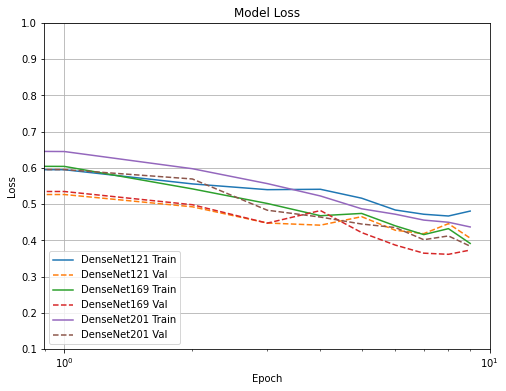

In [ ]:
plotter(histories)
histories={}

## **Various Models**

### InceptionResNetV2 Model

In [ ]:
# InceptionResNetV2 Model
model = InceptionResNetV2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)



In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "InceptionResNetV2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['InceptionResNetV2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.6854 - accuracy: 0.5776
Epoch 1: val_loss improved from inf to 0.62528, saving model to InceptionResNetV2_checkpoint.h5
40/40 [==============================] - 245s 5s/step - loss: 1.6854 - accuracy: 0.5776 - val_loss: 0.6253 - val_accuracy: 0.6690
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.6396
Epoch 2: val_loss improved from 0.62528 to 0.61798, saving model to InceptionResNetV2_checkpoint.h5
40/40 [==============================] - 210s 5s/step - loss: 0.6480 - accuracy: 0.6396 - val_loss: 0.6180 - val_accuracy: 0.6835
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6630
Epoch 3: val_loss improved from 0.61798 to 0.56838, saving model to InceptionResNetV2_checkpoint.h5
40/40 [==============================] - 204s 5s/step - loss: 0.6232 - accuracy: 0.6630 - val_loss: 0.5684 - val_accuracy: 0.7120
Epoch 4/10
40/40 [==============

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc =model.evaluate(test_generator)
print("InceptionResNetV2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 15s 2s/step - loss: 0.4887 - accuracy: 0.7805
InceptionResNetV2 Model's Test Accuracy Is 78.04999947547913%
Recall =  0.736


### InceptionV3 Model

In [ ]:
# InceptionV3 Model
model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "InceptionV3_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['InceptionV3']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 4.1142 - accuracy: 0.5354
Epoch 1: val_loss improved from inf to 0.65417, saving model to InceptionV3_checkpoint.h5
40/40 [==============================] - 189s 5s/step - loss: 4.1142 - accuracy: 0.5354 - val_loss: 0.6542 - val_accuracy: 0.6145
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.5974
Epoch 2: val_loss improved from 0.65417 to 0.62005, saving model to InceptionV3_checkpoint.h5
40/40 [==============================] - 174s 4s/step - loss: 0.6577 - accuracy: 0.5974 - val_loss: 0.6201 - val_accuracy: 0.6860
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.6339
Epoch 3: val_loss improved from 0.62005 to 0.60546, saving model to InceptionV3_checkpoint.h5
40/40 [==============================] - 187s 5s/step - loss: 0.6320 - accuracy: 0.6339 - val_loss: 0.6055 - val_accuracy: 0.7050
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("InceptionV3 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 6s 724ms/step - loss: 0.5354 - accuracy: 0.7675
InceptionV3 Model's Test Accuracy Is 76.74999833106995%
Recall =  0.774


### MobileNet Model

In [ ]:
# MobileNet Model
model = MobileNet(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)



In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "MobileNet_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['MobileNet']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 5.7293 - accuracy: 0.5693
Epoch 1: val_loss improved from inf to 0.61171, saving model to MobileNet_checkpoint.h5
40/40 [==============================] - 175s 4s/step - loss: 5.7293 - accuracy: 0.5693 - val_loss: 0.6117 - val_accuracy: 0.6805
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.6664
Epoch 2: val_loss improved from 0.61171 to 0.57243, saving model to MobileNet_checkpoint.h5
40/40 [==============================] - 176s 4s/step - loss: 0.6099 - accuracy: 0.6664 - val_loss: 0.5724 - val_accuracy: 0.7455
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.7020
Epoch 3: val_loss improved from 0.57243 to 0.53051, saving model to MobileNet_checkpoint.h5
40/40 [==============================] - 169s 4s/step - loss: 0.5619 - accuracy: 0.7020 - val_loss: 0.5305 - val_accuracy: 0.7650
Epoch 4/10
40/40 [==============================] - ETA:

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc =model.evaluate(test_generator)
print("MobileNet Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 5s 625ms/step - loss: 0.4022 - accuracy: 0.8270
MobileNet Model's Test Accuracy Is 82.70000219345093%
Recall =  0.885


### MobileNetV2 Model

In [ ]:
# MobileNetV2 Model
model = MobileNetV2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)



In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "MobileNetV2_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['MobileNetV2']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.9146 - accuracy: 0.6010
Epoch 1: val_loss improved from inf to 0.57344, saving model to MobileNetV2_checkpoint.h5
40/40 [==============================] - 199s 5s/step - loss: 1.9146 - accuracy: 0.6010 - val_loss: 0.5734 - val_accuracy: 0.7180
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.6848
Epoch 2: val_loss improved from 0.57344 to 0.53744, saving model to MobileNetV2_checkpoint.h5
40/40 [==============================] - 174s 4s/step - loss: 0.6109 - accuracy: 0.6848 - val_loss: 0.5374 - val_accuracy: 0.7420
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.7081
Epoch 3: val_loss improved from 0.53744 to 0.52515, saving model to MobileNetV2_checkpoint.h5
40/40 [==============================] - 172s 4s/step - loss: 0.5760 - accuracy: 0.7081 - val_loss: 0.5251 - val_accuracy: 0.7645
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("MobileNetV2 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 6s 645ms/step - loss: 0.4372 - accuracy: 0.8125
MobileNetV2 Model's Test Accuracy Is 81.25%
Recall =  0.787


### VGG16 Model

In [ ]:
# VGG16 Model
model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "VGG16_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['VGG16']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 3.9439 - accuracy: 0.5657
Epoch 1: val_loss improved from inf to 0.62593, saving model to VGG16_checkpoint.h5
40/40 [==============================] - 257s 6s/step - loss: 3.9439 - accuracy: 0.5657 - val_loss: 0.6259 - val_accuracy: 0.6620
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6447
Epoch 2: val_loss improved from 0.62593 to 0.58372, saving model to VGG16_checkpoint.h5
40/40 [==============================] - 207s 5s/step - loss: 0.6383 - accuracy: 0.6447 - val_loss: 0.5837 - val_accuracy: 0.7135
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6883
Epoch 3: val_loss improved from 0.58372 to 0.55898, saving model to VGG16_checkpoint.h5
40/40 [==============================] - 200s 5s/step - loss: 0.6019 - accuracy: 0.6883 - val_loss: 0.5590 - val_accuracy: 0.7495
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("VGG16 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 15s 2s/step - loss: 0.4629 - accuracy: 0.7895
VGG16 Model's Test Accuracy Is 78.94999980926514%
Recall =  0.845


### VGG19 Model

In [ ]:
# VGG19 Model
model = VGG19(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "VGG19_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['VGG19']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 4.2083 - accuracy: 0.5754
Epoch 1: val_loss improved from inf to 0.64460, saving model to VGG19_checkpoint.h5
40/40 [==============================] - 212s 5s/step - loss: 4.2083 - accuracy: 0.5754 - val_loss: 0.6446 - val_accuracy: 0.6800
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.6466
Epoch 2: val_loss improved from 0.64460 to 0.62031, saving model to VGG19_checkpoint.h5
40/40 [==============================] - 211s 5s/step - loss: 0.6464 - accuracy: 0.6466 - val_loss: 0.6203 - val_accuracy: 0.7115
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6742
Epoch 3: val_loss improved from 0.62031 to 0.58314, saving model to VGG19_checkpoint.h5
40/40 [==============================] - 211s 5s/step - loss: 0.6156 - accuracy: 0.6742 - val_loss: 0.5831 - val_accuracy: 0.7230
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 

In [ ]:
test_generator.reset
predictions =model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("VGG19 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 18s 2s/step - loss: 0.4666 - accuracy: 0.7855
VGG19 Model's Test Accuracy Is 78.54999899864197%
Recall =  0.857


### Xception Model

In [ ]:
# Xception Model
model = Xception(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))


83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Define new model
model = MakeModel(model)



In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "Xception_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['Xception']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 4.2318 - accuracy: 0.5615
Epoch 1: val_loss improved from inf to 0.64000, saving model to Xception_checkpoint.h5
40/40 [==============================] - 213s 5s/step - loss: 4.2318 - accuracy: 0.5615 - val_loss: 0.6400 - val_accuracy: 0.6380
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.6425
Epoch 2: val_loss improved from 0.64000 to 0.62018, saving model to Xception_checkpoint.h5
40/40 [==============================] - 197s 5s/step - loss: 0.6442 - accuracy: 0.6425 - val_loss: 0.6202 - val_accuracy: 0.6825
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6651
Epoch 3: val_loss improved from 0.62018 to 0.60160, saving model to Xception_checkpoint.h5
40/40 [==============================] - 195s 5s/step - loss: 0.6206 - accuracy: 0.6651 - val_loss: 0.6016 - val_accuracy: 0.7055
Epoch 4/10
40/40 [==============================] - ETA: 0s

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc =model.evaluate(test_generator)
print("Xception Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 12s 1s/step - loss: 0.5170 - accuracy: 0.7730
Xception Model's Test Accuracy Is 77.30000019073486%
Recall =  0.801


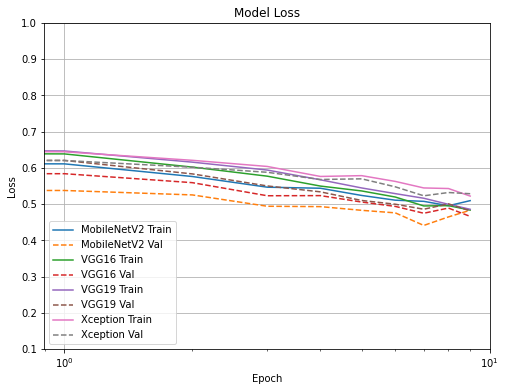

In [ ]:
plotter(histories)
histories={}

#**Training The Best Model On One Colour Channel**

## Defining Generators & preprocessing images to get red channel

In [ ]:
!mkdir /content/output/train_1
!mkdir /content/output/test_1
!mkdir /content/output/val_1
train_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/train"
test_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/test"
val_folder = "/content/Fake_Real_Faces/real_vs_fake/real-vs-fake/valid"
output_train = "/content/output/train_1"
output_test = "/content/output/test_1"
output_val = "/content/output/val_1"

splitfolders.ratio(train_folder, output=output_train , seed=42, ratio=(.1,.9))
splitfolders.ratio(test_folder , output=output_test  , seed=42, ratio=(.1,.9))
splitfolders.ratio(val_folder  , output=output_val   , seed=42, ratio=(.1,.9))

mkdir: cannot create directory ‘/content/output/train_1’: File exists
mkdir: cannot create directory ‘/content/output/test_1’: File exists
mkdir: cannot create directory ‘/content/output/val_1’: File exists


Copying files: 100000 files [02:27, 677.79 files/s]
Copying files: 20000 files [00:18, 1062.70 files/s]
Copying files: 20000 files [00:17, 1113.15 files/s]


In [ ]:
TRAIN_DIR_SAMPLE = os.path.join("/content/output/train_1", "train", "")
TEST_DIR_SAMPLE = os.path.join("/content/output/test_1", "train", "")
VAL_DIR_SAMPLE = os.path.join("/content/output/val_1", "train", "")

In [ ]:
import os
import glob
import cv2

# Reading the image using imread() function
# get the path/directory
folder_dir = "/content/output/train_1"
files = glob.glob(folder_dir + '/**/*.jpg', recursive=True)#all images in the folder
w = np.zeros([256,256,1],dtype=np.uint8)# empty channel
# For each image
for file in files:
    # Get File name and extension
    #filename = os.path.basename(file)
    image = cv2.imread(file) #open image
    b,g,r = cv2.split(image) #split channels
    image = cv2.merge([r, w, w]) # merge red channel with the red channel
    cv2.imwrite(file, image) # save the new image


In [ ]:
folder_dir = "/content/output/test_1"
files = glob.glob(folder_dir + '/**/*.jpg', recursive=True)

# For each image
for file in files:
    # Get File name and extension
    #filename = os.path.basename(file)
    image = cv2.imread(file)
    b,g,r = cv2.split(image)
    image = cv2.merge([r, w, w])
    cv2.imwrite(file, image)

In [ ]:
folder_dir = "/content/output/val_1"
files = glob.glob(folder_dir + '/**/*.jpg', recursive=True)
# For each image
for file in files:
    # Get File name and extension
    #filename = os.path.basename(file)
    image = cv2.imread(file)
    b,g,r = cv2.split(image)
    image = cv2.merge([r, w, w])
    cv2.imwrite(file, image)

In [ ]:
BATCH_SIZE = 256
HEIGHT = 256
WIDTH = 256

train_datagen_1_channel =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.densenet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=40,
      horizontal_flip=True,
    )

train_generator = train_datagen_1_channel.flow_from_directory(TRAIN_DIR_SAMPLE,
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 10000 images belonging to 2 classes.


In [ ]:
val_generator_1_channel = train_datagen.flow_from_directory(
    VAL_DIR_SAMPLE,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator_1_channel =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
    )

test_generator = test_generator_1_channel.flow_from_directory(TEST_DIR_SAMPLE,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = False,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


## Redefine Best Model

In [ ]:
# DenseNet201 Model
model = DenseNet201(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))



In [ ]:
# Define new model
model = MakeModel(model)


In [ ]:
model.compile(optimizer = Optimizer,
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
path_checkpoint = "DenseNet201_checkpoint.h5"

modelckpt_callback= keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
histories['DenseNet201']  = model.fit(
    train_generator,
    validation_data = val_generator,
    callbacks=[EarlyStopping, modelckpt_callback],
    epochs = EPOCHS)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 7.2740 - accuracy: 0.5419
Epoch 1: val_loss improved from inf to 0.67375, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 214s 5s/step - loss: 7.2740 - accuracy: 0.5419 - val_loss: 0.6737 - val_accuracy: 0.6130
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.5879
Epoch 2: val_loss improved from 0.67375 to 0.66213, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 193s 5s/step - loss: 0.6539 - accuracy: 0.5879 - val_loss: 0.6621 - val_accuracy: 0.6110
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.5992
Epoch 3: val_loss improved from 0.66213 to 0.63406, saving model to DenseNet201_checkpoint.h5
40/40 [==============================] - 193s 5s/step - loss: 0.6394 - accuracy: 0.5992 - val_loss: 0.6341 - val_accuracy: 0.6620
Epoch 4/10
40/40 [==============================] 

In [ ]:
test_generator.reset
predictions = model.predict_generator(test_generator, 2000 // BATCH_SIZE+1)
loss, acc = model.evaluate(test_generator)
print("DenseNet201 Model's Test Accuracy Is {}%".format(100*acc))
print("Recall = ",recall_score(test_generator.classes,(find_max(predictions)).round(), average='binary'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


8/8 [==============================] - 12s 1s/step - loss: 0.5175 - accuracy: 0.7775
DenseNet201 Model's Test Accuracy Is 77.74999737739563%
Recall =  0.807


# **Comments & Notes**

* Note: That the preprocessing function in the generators was changed accordingly with the pretrained models<br>

* Due to limited computational power we used 10% of the data as it took approximatly five hours to train one model with all of the data.<br>

* we noticed that training on one colour channel gave worse results than training on all 3 colour channels.

* The best accuracy was achieved by DenseNet201 while best recall was achieved by DenseNet169